In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, accuracy_score

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Reproducibility
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

In [3]:
# Load dataset
df = pd.read_csv("ecg_autoencoder_dataset.csv", header=None)

display(df.head())
print("Shape: ", df.shape)
print("Unique labels (last columns): ", pd.unique(df.iloc[:, -1]).tolist())

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


Shape:  (4998, 141)
Unique labels (last columns):  [1, 0]


In [4]:
# Features and Label
X = df.iloc[:, :-1].astype("float32").values
y = df.iloc[:, -1].astype("int").values

print("X shape: ", X.shape, "y shape: ", y.shape)
print("Label distribution: ", pd.Series(y).value_counts())

X shape:  (4998, 140) y shape:  (4998,)
Label distribution:  1    2919
0    2079
Name: count, dtype: int64


In [5]:
# train/test split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y, test_size=0.2, random_state = 42
)

# Determine which label value corresponds to normal (most frequent)
label_counts = pd.Series(y_train_all).value_counts()
normal_label_value = int(label_counts.idxmax())
anomaly_label_value = int(label_counts.idxmin())

print("Normal label value (most frequent): ", normal_label_value)
print("Anomaly label value (less frequent): ", anomaly_label_value)

Normal label value (most frequent):  1
Anomaly label value (less frequent):  0


In [6]:
# Keep only normal rows for autoencoder training
X_train_norm = X_train_all[y_train_all == normal_label_value]

print("Shapes -> All train: ", X_train_all.shape, "| Test: ", X_test_all.shape, "| Normal-train: ", X_train_norm.shape)

Shapes -> All train:  (3998, 140) | Test:  (1000, 140) | Normal-train:  (2328, 140)


In [8]:
# Normal train/validation split
Xn_train, Xn_val = train_test_split(X_train_norm, test_size=0.2, random_state=42)

print("Xn_train: ", Xn_train.shape, "| Xn_val: ", Xn_val.shape)

Xn_train:  (1862, 140) | Xn_val:  (466, 140)


In [9]:
# Scale normal-train only
scaler = MinMaxScaler().fit(Xn_train)
Xn_train_s = scaler.transform(Xn_train)
Xn_val_s = scaler.transform(Xn_val)
X_test_s = scaler.transform(X_test_all)
y_test = y_test_all.copy()

print("Scaled shapes:", Xn_train_s.shape, Xn_val_s.shape, X_test_s.shape)

Scaled shapes: (1862, 140) (466, 140) (1000, 140)


In [11]:
# Build autoencoder
INPUT_DIM = Xn_train_s.shape[1] # number of time samples / features per beat
INTERMEDIATE_DIM = 64
LATENT_DIM = 16

inp = Input(shape=(INPUT_DIM,), name="Input")
e = Dense(INTERMEDIATE_DIM, activation="relu", name="Encoder_L1")(inp)
e = Dense(32, activation="relu", name="Encoder_L2")(e)

latent = Dense(LATENT_DIM, activation="relu", name="Latent")(e)

d = Dense(32, activation="relu", name="Decoder_L1")(latent)
d = Dense(INTERMEDIATE_DIM, activation="relu", name="Decoder_L2")(d)
out = Dense(INPUT_DIM, activation="linear", name="Reconstruction")(d)

autoencoder = Model(inputs=inp, outputs=out, name="ECG_Autoencoder")
autoencoder.summary()

Model: "ECG_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_L1 (Dense)                   │ (None, 64)                  │           9,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_L2 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Latent (Dense)                       │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_L1 (Dense)                   │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_L2 (Dense)                   │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Reconstruction (Dense)               │ (None, 140)                 │           9,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,388 (91.36 KB)

 Trainable params: 23,388 (91.36 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile and Train
autoencoder.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mse"]
)

EPOCHS = 30
BATCH = 512

history = autoencoder.fit(
    Xn_train_s, Xn_train_s,
    validation_data=(Xn_val_s, Xn_val_s),
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    verbose=2
)

Epoch 1/30
4/4 - 2s - 429ms/step - loss: 0.2781 - mse: 0.2781 - val_loss: 0.2593 - val_mse: 0.2593
Epoch 2/30
4/4 - 0s - 24ms/step - loss: 0.2459 - mse: 0.2459 - val_loss: 0.2204 - val_mse: 0.2204
Epoch 3/30
4/4 - 0s - 24ms/step - loss: 0.2051 - mse: 0.2051 - val_loss: 0.1793 - val_mse: 0.1793
Epoch 4/30
4/4 - 0s - 23ms/step - loss: 0.1644 - mse: 0.1644 - val_loss: 0.1368 - val_mse: 0.1368
Epoch 5/30
4/4 - 0s - 27ms/step - loss: 0.1230 - mse: 0.1230 - val_loss: 0.0995 - val_mse: 0.0995
Epoch 6/30
4/4 - 0s - 27ms/step - loss: 0.0884 - mse: 0.0884 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 7/30
4/4 - 0s - 22ms/step - loss: 0.0617 - mse: 0.0617 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 8/30
4/4 - 0s - 25ms/step - loss: 0.0416 - mse: 0.0416 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 9/30
4/4 - 0s - 24ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 10/30
4/4 - 0s - 30ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 11/30
4/4 - 

In [15]:
# Reconstruction MSE per sample
def recon_error(model, data):
    recon = model.predict(data, verbose=0)
    return np.mean((data - recon) ** 2, axis=1)

err_val_norm = recon_error(autoencoder, Xn_val_s)
err_test = recon_error(autoencoder, X_test_s)

In [16]:
# Threshold selection
threshold = np.percentile(err_val_norm, 95)
print("Threshold (95th percentile of normal-val errors): ", threshold)

# Map ground-truth to common convention: y_true = 1 means anomaly
# If dataset used 'normal_label_value' for normal (e.g., 1), anomaly label is the other value
y_true = (y_test != normal_label_value).astype(int)

y_pred = (err_test > threshold).astype(int)

Threshold (95th percentile of normal-val errors):  0.03575744666159153


In [19]:
# Evaluation
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, err_test)
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {auc:.4f}")
print("Confusion Matrix:\n", cm)

Accuracy: 0.9030
Precision: 0.9171  Recall: 0.8386  F1: 0.8761  ROC-AUC: 0.9602
Confusion Matrix:
 [[560  31]
 [ 66 343]]


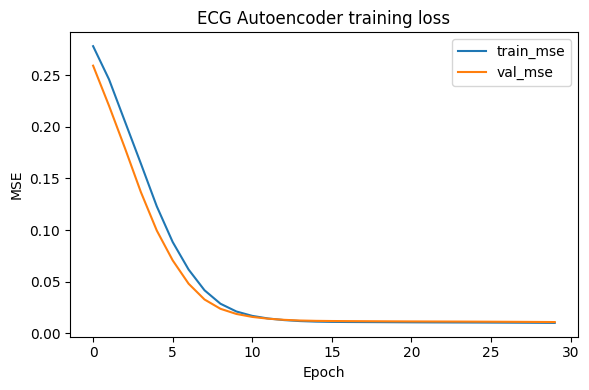

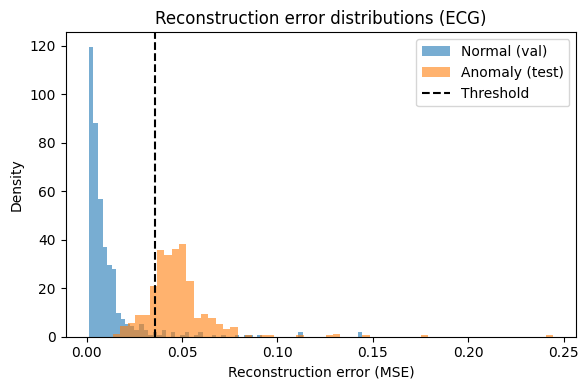

In [20]:
# training loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_mse")
plt.plot(history.history["val_loss"], label="val_mse")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("ECG Autoencoder training loss")
plt.legend(); plt.tight_layout(); plt.show()

# error histograms (density so minority is visible)
err_test_norm = err_test[y_true == 0]
err_test_anom = err_test[y_true == 1]

plt.figure(figsize=(6,4))
plt.hist(err_val_norm, bins=60, alpha=0.6, density=True, label="Normal (val)")
plt.hist(err_test_anom, bins=60, alpha=0.6, density=True, label="Anomaly (test)")
plt.axvline(threshold, color="k", linestyle="--", label="Threshold")
plt.xlabel("Reconstruction error (MSE)"); plt.ylabel("Density")
plt.title("Reconstruction error distributions (ECG)")
plt.legend(); plt.tight_layout(); plt.show()
